### Load data set with features

In [19]:
from create_df import read_df
df, dfc, all_homes, appliance_min, national_average = read_df()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [21]:
run all_functions.py

In [22]:
run features.py

In [23]:
import json

In [24]:
len(feature_map['15 min AMI']), len(feature_map['All']), len(feature_map['Monthly+Static']), len(feature_map['Monthly'])

(40, 43, 18, 15)

#### First round of CV, finding optimal features maximising median accuracy

In [25]:
out_mean, optimal_dict_mean = find_optimal_features(df, dfc, all_homes, appliance_min, national_average, 
                                                        ["hvac","light","fridge","dr","wm","dw"],
                                                        {"Static":feature_map["Static"],
                                                        'Monthly':feature_map['Monthly']},
                          NUM_NEIGHBOURS_MAX=7, F_length_max=7, metric="mean",
                          train_outlier=True, test_outlier=False, outlier_features=None, outlier_fraction=0.1,
                     print_steps=True)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
hvac
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
********************
Monthly
********************
include: aggregate_5 -> feature_subset: ['aggregate_5']. Accuracy: 75.9382086743
include: aggregate_7 -> feature_subset: ['aggregate_5', 'aggregate_7']. Accuracy: 77.5116843787
include: aggregate_9 -> feature_subset: ['aggregate_5', 'aggregate_7', 'aggregate_9']. Accuracy: 78.7938393707
include: difference_min_max -> feature_subset: ['aggregate_5', 'aggregate_7', 'aggregate_9', 'difference_min_max']. Accuracy: 78.2620497769
include: aggregate_10 -> feature_subset: ['aggregate_5', 'aggregate_7', 'aggregate_9', 'difference_min_max', 'aggregate_10']. Accuracy: 77.5073504609
include: aggregate_11 -> feature_subset: ['aggregate_5', 'aggregate_7', 'aggregate_9', 'difference_min_max', 'aggregate_10', 'aggregate_11']. Accuracy: 77.7383712215
include: aggregate_1 -> feature_subset: ['aggregate_5', 'aggregate_7', 'aggregate_9', 'difference_min_max', 'aggregate_

In [34]:
optimal_all_mean = json.load(open("without-test-optimal_dict.json","r"))

s = {}
for appliance in ['fridge','dw','dr','hvac','light','wm']:
    print appliance
    s[appliance] = {}
    for feature in ["All",'Monthly','Static']:
        s[appliance][feature] = {}
        if feature=="All":
            k=optimal_all_mean[appliance]['All']['k']
            f=optimal_all_mean[appliance]['All']['f']
            
        else:
            k=optimal_dict_mean[appliance][feature]['k']
            f=optimal_dict_mean[appliance][feature]['f']
            
            
        temp = create_predictions(df, dfc, all_homes, appliance_min,
                                          national_average, appliance=appliance, 
                                          feature=f,
                                          NUM_NEIGHBOURS=k, train_outlier=True, test_outlier=False,
                                          outlier_features=None, outlier_fraction=0.1)


        errors = {}
        if appliance =="hvac":
            start_month, end_month = 5, 11
        else:
            start_month, end_month = 1, 13
        for i in range(start_month, end_month):
            errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
        error_df = pd.DataFrame(errors)
        accur_df = 100-error_df
        accur_df[accur_df<0]=0
        tdf = accur_df
        if appliance =="hvac":
            for home in [624, 1953, 6636, 6836, 7769, 9922]:
                tdf.loc[home, 5]=np.NaN
                tdf.loc[home, 10]=np.NaN

        s[appliance][feature] = tdf.mean().mean()
            

fridge
dw
dr
hvac
light
wm


In [35]:
appliance_name_mapping = {"dr": "Dryer", "wm": "Washing\nmachine",
                          "fridge":"Fridge","light":"Lights",
                          "hvac":"HVAC","dw":"Dish\nwasher"}

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
sen = pd.DataFrame(s)

In [38]:
sen

,dr,dw,fridge,hvac,light,wm
All,43.676359,45.298867,81.121122,79.781058,49.873465,65.535383
Monthly,41.653005,43.502153,77.740660,79.807140,47.066094,64.363110
Static,40.787578,38.943083,75.182587,73.393153,48.235812,60.045676


In [39]:
sen = sen.rename(columns=appliance_name_mapping).T

In [40]:
from common_functions import latexify, format_axes
latexify()

tableau20blind =  [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
  
# Rescale to values between 0 and 1
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)

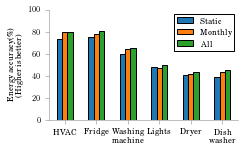

In [41]:
sen[['Static','Monthly','All']].ix[['HVAC','Fridge','Washing\nmachine',
                                    'Lights','Dryer','Dish\nwasher']].plot(kind="bar",rot=0, colors=tableau20blind[::2])
plt.ylim((0, 100));
plt.ylabel("Energy accuracy(\%)\n(Higher is better)");
plt.tight_layout()
format_axes(plt.gca())
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/features_sensitivity.pdf",bbox_inches="tight")
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/features_sensitivity.png",bbox_inches="tight")